# NLP Disaster Tweet Classification

## Overview

The goal of this project is to use sentiment analysis to classify tweets as disaster or non-disaster.

## Data

The data for this project was provided by the [Kaggle](https://www.kaggle.com/c/nlp-getting-started/overview) competition. The data contains the text of the tweet, a keyword and location (which may both be blank). The training data also contains a target classification (0 for non-disaster and 1 for disaster).



### Preprocessing

There are several steps we could take in regards to preprocessing: Tokenization, stop word removal, stemming, lowercasing, etc. However, due to the goal of this project, punctuation, capitalization, and special characters could end up being important features. For example, punctuation could indicate the type of disaster, and capitalization could indicate the severity of the disaster.

The steps we'll include are:

- Tokenization
- Stop word removal
- Punctuation removal
- Handling n-grams (bigrams)

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, SpatialDropout1D, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint


from gensim.models.phrases import Phrases, Phraser
from gensim.models.word2vec import Word2Vec

import string

#### Preparing and inspecting train, test, and validation data

In [2]:
train = pd.read_csv('./nlp-getting-started/train.csv')
test = pd.read_csv('./nlp-getting-started/test.csv')

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

In [179]:
print("Training data:")
print(train_df.shape)
print(train_df.columns)
print("Validation data:")
print(val_df.shape)
print(val_df.columns)


Training data:
(6090, 5)
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Validation data:
(1523, 5)
Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


In [5]:
# Dropping the keyword and location columns since they don't really provide any value
train_df = train_df.drop(columns=['keyword', 'location'])
val_df = val_df.drop(columns=['keyword', 'location'])
test_df = test.drop(columns=['keyword', 'location'])

print("Training data:")
print(train_df.shape)
print(train_df.columns)
print("Validation data:")
print(val_df.shape)
print(val_df.columns)
print("Test data:")
print(test_df.shape)
print(test_df.columns)


Training data:
(6090, 3)
Index(['id', 'text', 'target'], dtype='object')
Validation data:
(1523, 3)
Index(['id', 'text', 'target'], dtype='object')
Test data:
(3263, 2)
Index(['id', 'text'], dtype='object')


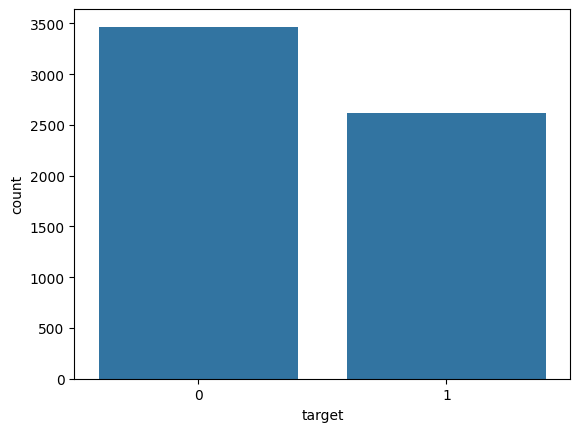

In [7]:
# Count how many of each classification there are in the training data
sns.countplot(x='target', data=train_df)
plt.show()

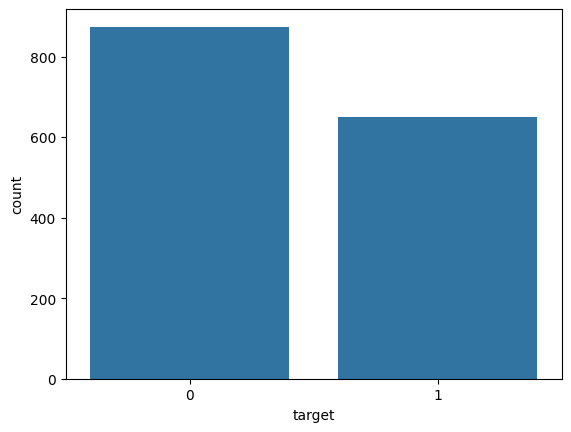

In [ ]:
# Count how many of each classification there are in the validation data
sns.countplot(x='target', data=val_df)
plt.show()

In [9]:
# Randomize the data
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)

# Create labels
train_labels = train_df['target']
val_labels = val_df['target']

# Displaying the first few rows of the data
print(train_df.head())
print(val_df.head())

     id                                               text  target
0  9376  Only one man Tsutomi Yamaguchi is said to have...       1
1  1632  It's been 70 years (and one hour) since the bo...       1
2  2656  Womem Crush Wednesday ?????????????????? @momm...       0
3  8657  Large sinkhole swallows entire pond in Lowndes...       1
4    24                                      I love fruits       0
     id                                               text  target
0  2489  2 pple have been confirmed dead and over 20 re...       1
1  7168  #GBBO The difference between Paul and Mary my ...       0
2  2709                Crushed it! https://t.co/EWnUnp8Hdo       0
3  1499  Womens Cross Body Messengers Bags Clutch Small...       0
4  3302  #charminar demolish if it in falling state any...       0


#### Tokenizing the text

In [10]:
# using NLTK's TweetTokenizer to tokenize the text 
tokenizer = TweetTokenizer(preserve_case=True, strip_handles=False, reduce_len=True)
train_df['text'] = train_df['text'].apply(tokenizer.tokenize)
val_df['text'] = val_df['text'].apply(tokenizer.tokenize)
test_df['text'] = test_df['text'].apply(tokenizer.tokenize)

# Displaying the first few rows of the training data
# The text is now tokenized, essentially a list of words
print(train_df.head())

     id                                               text  target
0  9376  [Only, one, man, Tsutomi, Yamaguchi, is, said,...       1
1  1632  [It's, been, 70, years, (, and, one, hour, ), ...       1
2  2656   [Womem, Crush, Wednesday, ?, ?, ?, @mommyisbomb]       0
3  8657  [Large, sinkhole, swallows, entire, pond, in, ...       1
4    24                                  [I, love, fruits]       0


In [13]:
# list of the 25 most common words in the training data
train_df['text'].explode().value_counts().head(25)


text
.       2648
the     2068
?       1784
:       1525
a       1481
to      1448
in      1433
of      1403
'       1105
and     1046
I       1043
!        885
...      843
-        807
is       674
for      672
on       634
        603
you      534
The      464
my       451
that     420
with     417
at       398
it       385
Name: count, dtype: int64

In [14]:
# The most common words don't seem to add much value, so we'll use the stopwords list and string.punctuation to remove them

stop_words = set(stopwords.words('english'))
train_df['text'] = train_df['text'].apply(lambda x: [word for word in x if word not in stop_words])
train_df['text'] = train_df['text'].apply(lambda x: [word for word in x if word not in string.punctuation])

val_df['text'] = val_df['text'].apply(lambda x: [word for word in x if word not in stop_words])
val_df['text'] = val_df['text'].apply(lambda x: [word for word in x if word not in string.punctuation])

test_df['text'] = test_df['text'].apply(lambda x: [word for word in x if word not in stop_words])
test_df['text'] = test_df['text'].apply(lambda x: [word for word in x if word not in string.punctuation])

In [15]:
# list of the 25 most common words in the training data
train_df['text'].explode().value_counts().head(25)

text
I             1043
...            843
              603
The            464
Û_             266
A              263
like           256
I'm            185
via            169
get            147
people         146
2              145
fire           136
In             120
one            118
would           99
..              99
3               93
California      89
To              85
This            85
got             84
new             84
video           83
time            81
Name: count, dtype: int64

In [17]:
# find the max length of the tweets
train_max = max([len(tweet) for tweet in train_df['text']])
print(f"Max length of training tweets: {train_max}")

val_max = max([len(tweet) for tweet in val_df['text']])
print(f"Max length of validation tweets: {val_max}")

test_max = max([len(tweet) for tweet in test_df['text']])
print(f"Max length of test tweets: {test_max}")

max_len = max(train_max, val_max, test_max)
print(f"Max length of all tweets: {max_len}")

Max length of training tweets: 30
Max length of validation tweets: 28
Max length of test tweets: 29
Max length of all tweets: 30


In [18]:
# Identify bigrams in the training data. This will help treat words that are frequently together as one token. For example, "United states", "New York", etc.

# Here we'll train a detector of bigrams
# min_count is the minimum number of times a bigram must appear to be included
# threshold is the minimum score of a bigram to be included
phrases = Phrases(train_df['text'], min_count=20, threshold=100)
bigram = Phraser(phrases)

# Below we'll output the count and score of the bigrams
bigram.phrasegrams

{'liked_@YouTube': 407.8241226300928,
 '@YouTube_video': 181.80111490739074,
 'mass_murder': 139.76903225806453,
 'Û_÷': 462.25177809388333,
 'Û_\x9d': 302.85461323392354,
 '#prebreak_#best': 640.9526627218935,
 'U_S': 280.28264840182646,
 'burning_buildings': 203.1336146272855,
 'suicide_bomber': 205.1534090909091,
 'oil_spill': 309.48857142857145,
 'Latest_More': 106.19705882352942,
 'Northern_California': 165.5904609034625,
 'Families_sue': 136.7689393939394,
 'Cross_Body': 355.73399014778323}

In [19]:
# Transform training set
train_tokens_bigrams = [bigram[doc] for doc in train_df['text']]
# Transform validation set
val_tokens_bigrams = [bigram[doc] for doc in val_df['text']]
# Transform test set
test_tokens_bigrams = [bigram[doc] for doc in test_df['text']]

#### Transforming words (tokens) into vectors using Word2Vec

In [20]:
# Below we'll use Word2Vec to create a vector representation of the text
# Parameters were changed several times to try to improve similarity between words/vectors

tweets_vec = Word2Vec(
    sentences=train_tokens_bigrams, 
    vector_size=512, #Starting with 32 dimensions, but moved up to 512
    sg=0, #Using CBOW model, which uses the context words to predict the target word
    window=10, #Window size
    epochs=75, #Number of iterations
    min_count=1, #Minimum times a word occurs in the training data before it is included
    workers=8 #Number of CPU cores allowed
    )

In [21]:
# Output and size of vocab in word vector
print(len(tweets_vec.wv))
# Output the vector for a random word
print(tweets_vec.wv["fire"])

23195
[ 1.83848754e-01 -2.00556302e+00  1.47283363e+00  1.37191784e+00
 -7.46567100e-02  1.25427282e+00 -7.08844543e-01 -3.19620490e+00
  1.42220926e+00 -1.24448419e-01 -8.95824373e-01 -1.18664098e+00
 -1.54878184e-01 -3.07177901e+00  1.79523742e+00  2.26327610e+00
  4.86064881e-01  7.67978549e-01  1.35127461e+00 -6.25556856e-02
  1.84519804e+00  5.34162998e-01  1.72263849e+00  3.04507613e+00
  8.75305086e-02 -7.33386353e-02  8.42540026e-01  2.27931380e+00
 -2.49785304e-01  5.65166585e-02  7.45526493e-01 -5.95497936e-02
 -2.44087982e+00 -3.69675469e+00  1.70845640e+00  1.43089914e+00
  2.22939658e+00 -2.47443128e+00 -2.37722278e-01 -8.08712840e-01
  8.97165060e-01 -2.59814358e+00 -1.11137044e+00  1.47262788e+00
  1.56749642e+00  1.74217808e+00  3.77824664e-01  3.66418749e-01
  1.44259882e+00 -1.51357844e-01 -8.39738369e-01  4.28404033e-01
  1.02084315e+00  5.30653894e-02 -1.86292386e+00 -7.36741900e-01
  9.01810884e-01 -2.06106186e+00 -1.77192891e+00  3.83148789e-02
  5.33105075e-01 -1

In [22]:
# find similar words to "lightning"
print(tweets_vec.wv.most_similar("father", topn=3))

print(tweets_vec.wv.most_similar("lightning", topn=3))

print(tweets_vec.wv.most_similar("fire", topn=3))

[('biological', 0.8982880115509033), ('adoptive', 0.7905646562576294), ('Criminal', 0.7827234268188477)]
[('Dry', 0.829822301864624), ('downpours', 0.8166969418525696), ('filmed', 0.8161824941635132)]
[('truck', 0.9012472629547119), ('apartment', 0.881073534488678), ('http://t.co/h31Knuwzz5', 0.8653009533882141)]


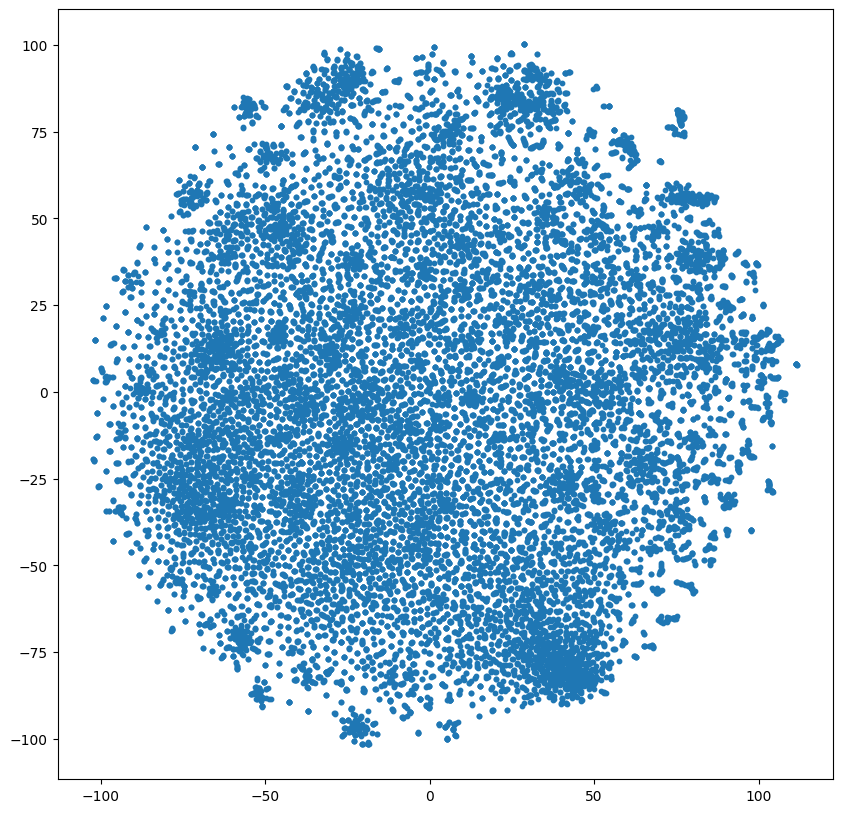

In [ ]:
# Plotting word vectors using dimensionality reduction using T-SNE
# This will roughly represent the vector mapping in 2D
# This is a good way to visualize the vector space and see how similar words are to each other
tsne = TSNE(n_components=2, random_state=42)
word_vectors_2d = tsne.fit_transform(tweets_vec.wv.vectors)

# Plotting the word vectors
plt.figure(figsize=(10, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], s=10)

#### Converting the tokens into embedding sequences
This represents tweets as a sequence of tokens, which is useful for RNN-based models


In [30]:
# Convert tokens to embedding sequences
def tokens_to_embedding_sequence(tokens, model, max_len):
    embedding_dim = model.vector_size
    seq = []
    for token in tokens:
        if token in model.wv:
            seq.append(model.wv[token])
        else:
            seq.append(np.zeros(embedding_dim))
    # RIGHT-PAD with zeros
    if len(seq) < max_len:
        seq += [np.zeros(embedding_dim)] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return np.array(seq)

In [31]:
train_sequences = np.array([tokens_to_embedding_sequence(tokens, tweets_vec, max_len) for tokens in train_tokens_bigrams])
val_sequences = np.array([tokens_to_embedding_sequence(tokens, tweets_vec, max_len) for tokens in val_tokens_bigrams])
test_sequences = np.array([tokens_to_embedding_sequence(tokens, tweets_vec, max_len) for tokens in test_tokens_bigrams])

In [80]:
print(train_sequences.shape)  # (num_samples, max_len, embedding_dim)
print(val_sequences.shape)
print(train_sequences.dtype)  # float64

(6090, 30, 512)
(1523, 30, 512)
float64


In [81]:
print(np.isnan(train_sequences).sum(), np.isinf(train_sequences).sum())
print(np.isnan(val_sequences).sum(), np.isinf(val_sequences).sum())

0 0
0 0


#### Building the RNN model
This is a simple RNN model with two GRU layers, with a ReLU-activated dense layer and a sigmoid activation function for the output layer. 


In [140]:
model = Sequential([
    GRU(64, input_shape=(max_len, tweets_vec.vector_size), return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/lmarte/Documents/Projects/CU-Boulder/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [141]:
model.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_45 (GRU)                    │ (None, 30, 64)         │       110,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_46 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,473 (474.50 KB)

 Trainable params: 121,473 (474.50 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
# Added this to make sure we get the best performing model before any overfitting occurs
checkpoint = ModelCheckpoint(
    'best_gru_model.h5',
    monitor='val_accuracy', 
    save_best_only=True,
    mode='max',          
    verbose=1
)

In [143]:
model.fit(train_sequences, train_labels, 
          validation_data=(val_sequences, val_labels), 
          epochs=20, 
          batch_size=32,
          callbacks=[checkpoint]
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5634 - loss: 0.7197
Epoch 1: val_accuracy improved from -inf to 0.65529, saving model to best_gru_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5633 - loss: 0.7200 - val_accuracy: 0.6553 - val_loss: 0.6372
Epoch 2/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6438 - loss: 0.6676
Epoch 2: val_accuracy improved from 0.65529 to 0.72817, saving model to best_gru_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6444 - loss: 0.6671 - val_accuracy: 0.7282 - val_loss: 0.5468
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7257 - loss: 0.5768
Epoch 3: val_accuracy improved from 0.72817 to 0.75509, saving model to best_gru_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7256 - loss: 0.5768 - val_accuracy: 0.7551 - val_loss: 0.5160
Epoch 4/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7516 - loss: 0.5245
Epoch 4: val_accuracy did not improve from 0.75509
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7516 - loss: 0.5245 - val_accuracy: 0.7531 - val_loss: 0.5005
Epoch 5/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7586 - loss: 0.5225
Epoch 5: val_accuracy improved from 0.75509 to 0.76231, saving model to best_gru_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7586 - loss: 0.5224 - val_accuracy: 0.7623 - val_loss: 0.4989
Epoch 6/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7731 - loss: 0.4903
Epoch 6: val_accuracy improved from 0.76231 to 0.77216, saving model to best_gru_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7731 - loss: 0.4903 - val_accuracy: 0.7722 - val_loss: 0.4962
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7798 - loss: 0.4834
Epoch 7: val_accuracy did not improve from 0.77216
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7798 - loss: 0.4833 - val_accuracy: 0.7702 - val_loss: 0.4904
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7842 - loss: 0.4632
Epoch 8: val_accuracy did not improve from 0.77216
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7841 - loss: 0.4632 - val_accuracy: 0.7525 - val_loss: 0.5165
Epoch 9/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7875 - loss: 0.4581
Epoch 9: val_accuracy did not improve from 0.77216
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7875 - loss: 0.4582 - val_accuracy: 0.7722 - val_loss: 0.4952
Epoch 10/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7969 - loss: 0.4380
Epoch 10: val_accuracy imp

191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7968 - loss: 0.4382 - val_accuracy: 0.7761 - val_loss: 0.5109
Epoch 11/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7985 - loss: 0.4312
Epoch 11: val_accuracy did not improve from 0.77610
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7985 - loss: 0.4313 - val_accuracy: 0.7728 - val_loss: 0.5089
Epoch 12/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7941 - loss: 0.4428
Epoch 12: val_accuracy improved from 0.77610 to 0.77807, saving model to best_gru_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7941 - loss: 0.4428 - val_accuracy: 0.7781 - val_loss: 0.5057
Epoch 13/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7953 - loss: 0.4384
Epoch 13: val_accuracy did not improve from 0.77807
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7954 - loss: 0.4384 - val_accuracy: 0.7630 - val_loss: 0.5167
Epoch 14/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7973 - loss: 0.4430
Epoch 14: val_accuracy did not improve from 0.77807
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7973 - loss: 0.4430 - val_accuracy: 0.7708 - val_loss: 0.5248
Epoch 15/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7990 - loss: 0.4363
Epoch 15: val_accuracy did not improve from 0.77807
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7990 - loss: 0.4362 - val_accuracy: 0.7741 - val_loss: 0.5135
Epoch 16/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8056 - loss: 0.4168
Epoch 16: val_accura

In [144]:
model.load_weights('best_gru_model.h5')

In [145]:
y_pred_probs = model.predict(val_sequences)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


### Evaluate GRU-based model

F1 Score: 0.7178631051752922


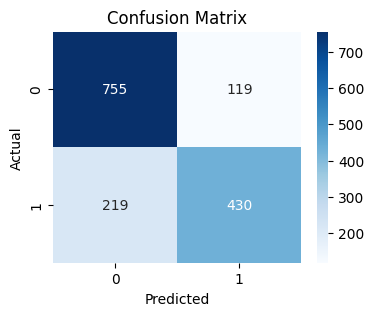

In [146]:
cm = confusion_matrix(val_labels, y_pred)
f1 = f1_score(val_labels, y_pred)

print("F1 Score:", f1)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

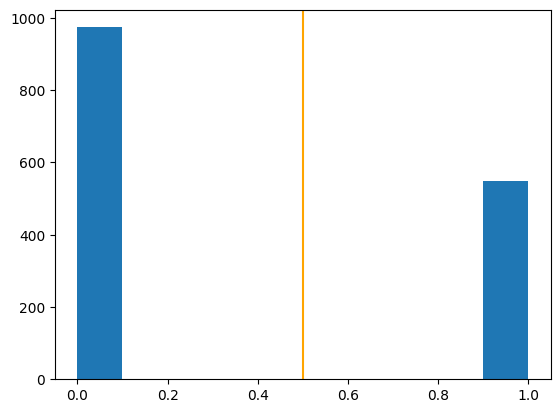

In [147]:
plt.hist(y_pred)
_ = plt.axvline(x=0.5, color='orange')

In [150]:
"{:0.2f}".format(roc_auc_score(val_labels, y_pred)*100.0)

'76.32'

#### Build ConvNet-LSTM Model
This approach is based on the textbook "Deep Learning Illustrated" by Jon Krohn, where a similar architecture is used classifying IMDB movie reviews.

In [153]:
model = Sequential([
    Conv1D(
        filters=128, kernel_size=3, 
        input_shape=(max_len, tweets_vec.vector_size), 
        activation='relu', padding='same'
        ),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/lmarte/Documents/Projects/CU-Boulder/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [154]:
model.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 128)        │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,369 (978.00 KB)

 Trainable params: 250,369 (978.00 KB)

 Non-trainable params: 0 (0.00 B)

In [155]:
lstm_checkpoint = ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_accuracy', 
    save_best_only=True,            
    mode='max',                     
    verbose=1
)
model.fit(train_sequences, train_labels, 
          validation_data=(val_sequences, val_labels), 
          epochs=20, 
          batch_size=32,
          callbacks=[lstm_checkpoint]
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6856 - loss: 0.5945
Epoch 1: val_accuracy improved from -inf to 0.73999, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6858 - loss: 0.5943 - val_accuracy: 0.7400 - val_loss: 0.5579
Epoch 2/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7609 - loss: 0.5174
Epoch 2: val_accuracy improved from 0.73999 to 0.75640, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7609 - loss: 0.5173 - val_accuracy: 0.7564 - val_loss: 0.4988
Epoch 3/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7731 - loss: 0.4853
Epoch 3: val_accuracy improved from 0.75640 to 0.76362, saving model to best_lstm_model.h5


191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7731 - loss: 0.4853 - val_accuracy: 0.7636 - val_loss: 0.4984
Epoch 4/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7820 - loss: 0.4736
Epoch 4: val_accuracy did not improve from 0.76362
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7820 - loss: 0.4737 - val_accuracy: 0.7557 - val_loss: 0.5206
Epoch 5/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7786 - loss: 0.4732
Epoch 5: val_accuracy did not improve from 0.76362
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7787 - loss: 0.4731 - val_accuracy: 0.7577 - val_loss: 0.5017
Epoch 6/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7947 - loss: 0.4470
Epoch 6: val_accuracy did not improve from 0.76362
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7946 - loss: 0.4470 - val_accuracy: 0.7584 - val_loss: 0.5208
Epoch 7/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8013 - loss: 0.4363
Epoch 7: val_accuracy impro

191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8013 - loss: 0.4363 - val_accuracy: 0.7735 - val_loss: 0.5002
Epoch 8/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8183 - loss: 0.4145
Epoch 8: val_accuracy did not improve from 0.77347
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8182 - loss: 0.4146 - val_accuracy: 0.7597 - val_loss: 0.5235
Epoch 9/20
188/191 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8175 - loss: 0.4070
Epoch 9: val_accuracy did not improve from 0.77347
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8174 - loss: 0.4072 - val_accuracy: 0.7715 - val_loss: 0.5228
Epoch 10/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8291 - loss: 0.3869
Epoch 10: val_accuracy did not improve from 0.77347
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8290 - loss: 0.3872 - val_accuracy: 0.7439 - val_loss: 0.5495
Epoch 11/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8245 - loss: 0.3872
Epoch 11: val_accuracy d

In [156]:
model.load_weights('best_lstm_model.h5')
y_pred_probs = model.predict(val_sequences)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
### Evaluate LSTM model
cm = confusion_matrix(val_labels, y_pred)
f1 = f1_score(val_labels, y_pred)


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


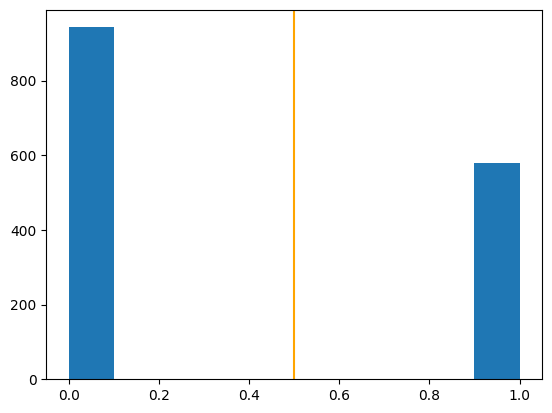

In [157]:
plt.hist(y_pred)
_ = plt.axvline(x=0.5, color='orange')

F1 Score: 0.7192839707078926


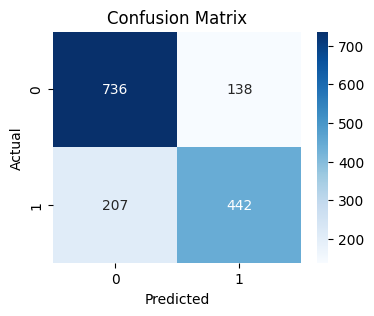

In [ ]:
print("F1 Score:", f1)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [160]:
"{:0.2f}".format(roc_auc_score(val_labels, y_pred)*100.0)

'76.16'

### Prediction using test data

In [162]:
# Predicting the test data
y_pred_probs = model.predict(test_sequences)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Creating a submission file
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': y_pred
})
submission.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### Conclusion
- Both models performed similarly, with the ConvNet-LSTM model slightly outperforming the GRU-based model.